In [1]:
# Import libraries
from dynamita.sumo import *

import numpy as np
import time
import copy as cp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
%matplotlib notebook

In [3]:
# Specify path where Sumo is found and Sumo license
sumo = Sumo(sumoPath="C:/Users/Sara/AppData/Local/Dynamita/Sumo19",
           licenseFile=r"C:/Users/Sara/Desktop/sewerWRRF/networklicense.sumolic")

License OK...


To load and run a dynamic input:
1. Save the dynamic input(s) in a .tsv file.
  - To make this easy, you can first do it from the Sumo GUI. This will create a .tsv file in the project's temporary directory (View > Directories > Project Directory) and "loadtsv ..." will be logged in the Core Window.
2. Copy the new initialization script and dynamic influent .tsv file into the working folder.
3. Make sure the command "loadtsv ... xxx.tsv" is in the initialization script. 
  - If it is not there, find it in the Core Window and paste it into the initialization script (the one in the working folder). It shouldn't matter where it is in the script.
  - Make sure the .tsv file path is updated to the working folder.
  - This step can also be done via calls in Python: `command = 'loadtsv '+ TSV +' ;'` and `sumo.core.csumo_command_send(sumo.handle, command.encode('utf8'))` where `TSV` is the .tsv file.

In [4]:
# Unload any models and load Sumo model of interest
sumo.unload_model()
sumo.load_model('A2O plant_dynamic.sumo')

# Specify initialization script for Sumo model included above
sumo.core.csumo_command_send(sumo.handle, b'execute script_Initialize_dynamic.scs;')

# Write commands for pulling and storing Sumo variables based on variable positions
def datacomm_callback(sumo):
    t_set.append(sumo.core.csumo_var_get_time_double(sumo.handle))
    
    q_infl_set.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, q_infl_pos))
    snhx_infl_set.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, snhx_infl_pos))
    xtss_infl_set.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, xtss_infl_pos))
    
    q_effl_set.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, q_effl_pos))
    snhx_effl_set.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, snhx_effl_pos))
    xtss_effl_set.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, xtss_effl_pos))
    
    return 0

sumo.register_datacomm_callback(datacomm_callback)

# Write function for printing Sumo commands (e.g., initiating and running model simulations)
def message_callback(sumo):
    for message in sumo.messages:
        print(message)
    sumo.messages = []
    return 0

sumo.register_message_callback(message_callback)

# Specify the length of the simulation and the frequency at which variables will be reported
# These are required in milliseconds
sumo.set_stopTime(16*24*60*60*1000)
sumo.set_dataComm(50*60*1000)

No model is loaded
530021 Set: Sumo__StopTime to 0
530021 Set: Sumo__DataComm to 3600000
530021 Set: Sumo__PlantName to C:\Users\DYNAMI~1\AppData\Local\Dynamita\Sumo18\TMP~1\xjzoiwqs.cba\SUMOPR~1.XML
530049 Core loop started.
530036 Script file script_Initialize_dynamic.scs loaded.
530007 Path set to: "C:/Users/Sara/AppData/Local/Dynamita/Sumo19/.tmp/t0g5mkii.lrm".
530020 Set mode: dynamic
530021 Set: Sumo__Plant__CSTR__param__L_V to 1000

In [5]:
# Store positions for variables of interest
q_infl_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__Influent__Q')
snhx_infl_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__Influent__SNHx')
xtss_infl_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__Influent__XTSS')

q_effl_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__Effluent__Q')
snhx_effl_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__Effluent__SNHx')
xtss_effl_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__Effluent__XTSS')


530021 Set: Sumo__Plant__CSTR__param__Qair_N to 0
530021 Set: Sumo__Plant__CSTR2__param__L_V to 1500
530021 Set: Sumo__Plant__CSTR2__param__Qair_N to 0
530021 Set: Sumo__Plant__CSTR3__param__L_V to 4500
530021 Set: Sumo__Plant__Sideflowdivider__param__Qpumped_target to 72000
530030 TSV file "C:\Users\Sara\Desktop\sewerWRRF\SumoPythonPractice\Influent_Table1.tsv" loaded.
530021 Set: Sumo__StopTime to 1382400000
530021 Set: Sumo__DataComm to 3000000


In [6]:
# Specify .tsv for reading the steady-state influent data
r_influentTSV = 'C:/Users/Sara/Desktop/sewerWRRF/SumoPythonPractice/Influent_Table_step_base.tsv'

In [7]:
# Load changed .tsv file to Sumo
command = 'loadtsv '+ r_influentTSV +' ;'
sumo.core.csumo_command_send(sumo.handle, command.encode('utf8'))

1

530030 TSV file "C:/Users/Sara/Desktop/sewerWRRF/SumoPythonPractice/Influent_Table_step_base.tsv" loaded.


In [8]:
# Initiate lists for variables to store
t_set = []
q_infl_set = []
snhx_infl_set = []
xtss_infl_set = []

q_effl_set = []
snhx_effl_set = []
xtss_effl_set = []

# Run Sumo model simulation
sumo.run_model()

# Sleep until the simulation is complete
while not sumo.simulation_finished:
    time.sleep(0.01)

530002 Simulation started.
530004 Simulation ended.


In [9]:
data_base = {}
data_base['t'] = t_set
data_base['q_infl'] = q_infl_set
data_base['snhx_infl'] = snhx_infl_set
data_base['xtss_infl'] = xtss_infl_set
data_base['q_effl'] = q_effl_set
data_base['snhx_effl'] = snhx_effl_set
data_base['xtss_effl'] = xtss_effl_set

df_base = pd.DataFrame.from_dict(data_base)
df_base.set_index('t')

,q_infl,snhx_infl,xtss_infl,q_effl,snhx_effl,xtss_effl
t,,,,,,
0.000000,24000.0,24.0,182.983467,23173.007614,1.000000,3324.747492
0.034722,24000.0,24.0,182.983467,23173.007614,0.836991,2587.804905
0.069444,24000.0,24.0,182.983467,23173.007614,0.700267,2014.695425
0.104167,24000.0,24.0,182.983467,23173.007614,0.624942,1569.007472
0.138889,24000.0,24.0,182.983467,23173.007614,0.567993,1222.416126
...,...,...,...,...,...,...
15.833333,24000.0,24.0,182.983467,23173.007614,0.471491,10.000001
15.868056,24000.0,24.0,182.983467,23173.007614,0.471460,10.000000
15.902778,24000.0,24.0,182.983467,23173.007614,0.471429,10.000000


### Change influent step value

In [26]:
# Specify .tsv for reading the diurnal influent data
r_influentTSV = 'C:/Users/Sara/Desktop/sewerWRRF/SumoPythonPractice/Influent_Table_step_base.tsv'
w_influentTSV = 'C:/Users/Sara/Desktop/sewerWRRF/SumoPythonPractice/Influent_Table_step.tsv'

# Read the original .tsv file as a pandas table
r_influentTSV_data = pd.read_table(r_influentTSV, sep='\t')

stepMags = [26000, 28000, 30000, 34000, 40000, 48000, 56000, 64000, 70000]
q_infl_diff = [0]
q_effl_diff = [0]
snhx_effl_diff = [0]

In [27]:
for j in stepMags:
    print('Step magnitude: ' + str(j) \n)
    
    # Make a change to the original .tsv file
    for i in range(9,16):
        r_influentTSV_data.loc[i]["Sumo__Plant__Influent__param__Q"] = j
        r_influentTSV_data
        
    # Write the changed .tsv file to a new file
    with open(w_influentTSV,'w') as write_tsv:
        write_tsv.write(r_influentTSV_data.to_csv(sep='\t', index=False))
    
    # Load changed .tsv file to Sumo
    command = 'loadtsv '+ w_influentTSV +' ;'
    sumo.core.csumo_command_send(sumo.handle, command.encode('utf8'))
    
    # Rerun Sumo simulation
    t_set = []
    q_infl_set = []; snhx_infl_set = []; xtss_infl_set = []
    q_effl_set = []; snhx_effl_set = []; xtss_effl_set = []
    
    sumo.run_model()
    
    while not sumo.simulation_finished:
        time.sleep(0.01)
    
    # Unload changed .tsv file to Sumo
    command = 'unloadtsv '+ w_influentTSV +' ;'
    sumo.core.csumo_command_send(sumo.handle, command.encode('utf8'))
    
    data_small = {}
    data_small['t'] = t_set
    data_small['q_infl'] = q_infl_set; data_small['snhx_infl'] = snhx_infl_set; data_small['xtss_infl'] = xtss_infl_set
    data_small['q_effl'] = q_effl_set; data_small['snhx_effl'] = snhx_effl_set; data_small['xtss_effl'] = xtss_effl_set
    
    df_small = pd.DataFrame.from_dict(data_small)
    df_small.set_index('t')
    
    q_infl_diff.append(max(df_small['q_infl'] - df_base['q_infl']))
    q_effl_diff.append(max(df_small['q_effl'] - df_base['q_effl']))
    snhx_effl_diff.append(max(df_small['snhx_effl'] - df_base['snhx_effl']))

Step magnitude: 26000
530030 TSV file "C:/Users/Sara/Desktop/sewerWRRF/SumoPythonPractice/Influent_Table_step.tsv" loaded.
530002 Simulation started.
530004 Simulation ended.
530021 Set: Sumo__Plant__Influent__param__Q to 24000Step magnitude: 28000
530050 TSV file "C:/Users/Sara/Desktop/sewerWRRF/SumoPythonPractice/Influent_Table_step.tsv" unloaded.

530030 TSV file "C:/Users/Sara/Desktop/sewerWRRF/SumoPythonPractice/Influent_Table_step.tsv" loaded.
530002 Simulation started.
530004 Simulation ended.
Step magnitude: 30000530021 Set: Sumo__Plant__Influent__param__Q to 24000
530050 TSV file "C:/Users/Sara/Desktop/sewerWRRF/SumoPythonPractice/Influent_Table_step.tsv" unloaded.

530030 TSV file "C:/Users/Sara/Desktop/sewerWRRF/SumoPythonPractice/Influent_Table_step.tsv" loaded.
530002 Simulation started.
530004 Simulation ended.
Step magnitude: 34000530021 Set: Sumo__Plant__Influent__param__Q to 24000
530050 TSV file "C:/Users/Sara/Desktop/sewerWRRF/SumoPythonPractice/Influent_Table_step.t

<IPython.core.display.Javascript object>


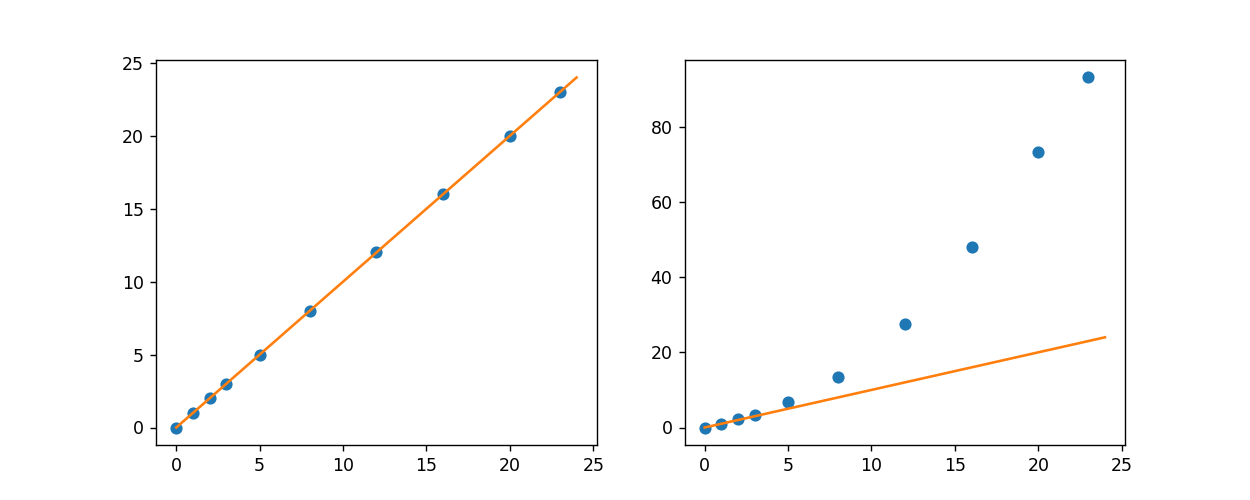

In [32]:
fig, axes = plt.subplots(1,2, figsize=(10,4))

axes[0].plot(np.divide(q_infl_diff,q_infl_diff[1]), np.divide(q_effl_diff,q_effl_diff[1]), 'o')
axes[0].plot([0,24], [0,24])

axes[1].plot(np.divide(q_infl_diff,q_infl_diff[1]), np.divide(snhx_effl_diff,snhx_effl_diff[1]), 'o')
axes[1].plot([0,24], [0,24])

### Small step influent

In [ ]:
# Specify .tsv for reading the diurnal influent data
r_influentTSV = 'C:/Users/Sara/Desktop/sewerWRRF/SumoPythonPractice/Influent_Table_step_small.tsv'

In [ ]:
# Load changed .tsv file to Sumo
command = 'loadtsv '+ r_influentTSV +' ;'
sumo.core.csumo_command_send(sumo.handle, command.encode('utf8'))

In [ ]:
# Rerun Sumo simulation
t_set = []
q_infl_set = []
snhx_infl_set = []
xtss_infl_set = []

q_effl_set = []
snhx_effl_set = []
xtss_effl_set = []

sumo.run_model()

while not sumo.simulation_finished:
    time.sleep(0.01)

In [ ]:
data_small = {}
data_small['t'] = t_set
data_small['q_infl'] = q_infl_set
data_small['snhx_infl'] = snhx_infl_set
data_small['xtss_infl'] = xtss_infl_set
data_small['q_effl'] = q_effl_set
data_small['snhx_effl'] = snhx_effl_set
data_small['xtss_effl'] = xtss_effl_set

df_small = pd.DataFrame.from_dict(data_small)
df_small.set_index('t')

### Medium step influent

In [ ]:
# Specify .tsv for reading the diurnal influent data
r_influentTSV = 'C:/Users/Sara/Desktop/sewerWRRF/SumoPythonPractice/Influent_Table_step_med.tsv'

In [ ]:
# Load changed .tsv file to Sumo
command = 'loadtsv '+ r_influentTSV +' ;'
sumo.core.csumo_command_send(sumo.handle, command.encode('utf8'))

In [ ]:
# Rerun Sumo simulation
t_set = []
q_infl_set = []
snhx_infl_set = []
xtss_infl_set = []

q_effl_set = []
snhx_effl_set = []
xtss_effl_set = []

sumo.run_model()

while not sumo.simulation_finished:
    time.sleep(0.01)

In [ ]:
data_med = {}
data_med['t'] = t_set
data_med['q_infl'] = q_infl_set
data_med['snhx_infl'] = snhx_infl_set
data_med['xtss_infl'] = xtss_infl_set
data_med['q_effl'] = q_effl_set
data_med['snhx_effl'] = snhx_effl_set
data_med['xtss_effl'] = xtss_effl_set

df_med = pd.DataFrame.from_dict(data_med)
df_med.set_index('t')

### Large step influent

In [ ]:
# Specify .tsv for reading the diurnal influent data
r_influentTSV = 'C:/Users/Sara/Desktop/sewerWRRF/SumoPythonPractice/Influent_Table_step_large.tsv'

In [ ]:
# Load changed .tsv file to Sumo
command = 'loadtsv '+ r_influentTSV +' ;'
sumo.core.csumo_command_send(sumo.handle, command.encode('utf8'))

In [ ]:
# Rerun Sumo simulation
t_set = []
q_infl_set = []
snhx_infl_set = []
xtss_infl_set = []

q_effl_set = []
snhx_effl_set = []
xtss_effl_set = []

sumo.run_model()

while not sumo.simulation_finished:
    time.sleep(0.01)

In [ ]:
data_large = {}
data_large['t'] = t_set
data_large['q_infl'] = q_infl_set
data_large['snhx_infl'] = snhx_infl_set
data_large['xtss_infl'] = xtss_infl_set
data_large['q_effl'] = q_effl_set
data_large['snhx_effl'] = snhx_effl_set
data_large['xtss_effl'] = xtss_effl_set

df_large = pd.DataFrame.from_dict(data_large)
df_large.set_index('t')

In [ ]:
df_large.plot(x = 't', kind='line', subplots='True', layout=(2,3))

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(10,4))

axes[0].plot(df_base['t'], df_base['q_infl'])
axes[0].plot(df_small['t'], df_small['q_infl'])
axes[0].plot(df_large['t'], df_med['q_infl'])
axes[0].plot(df_large['t'], df_large['q_infl'])

axes[1].plot(df_base['t'], df_base['q_effl'])
axes[1].plot(df_small['t'], df_small['q_effl'])
axes[1].plot(df_large['t'], df_med['q_effl'])
axes[1].plot(df_large['t'], df_large['q_effl'])

axes[2].plot(df_base['t'], df_base['snhx_effl'])
axes[2].plot(df_small['t'], df_small['snhx_effl'])
axes[2].plot(df_small['t'], df_med['snhx_effl'])
axes[2].plot(df_large['t'], df_large['snhx_effl'])

axes[0].set_xlim((7,15))
axes[1].set_xlim((7,15))
axes[2].set_xlim((7,15))
axes[2].set_ylim((0.45,0.6))

axes[0].set_ylabel('Q influent')
axes[1].set_ylabel('Q effluent')
axes[2].set_ylabel('SNHx effluent')

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(10,4))

axes[0].plot(df_small['t'], (df_small['q_infl'] - df_base['q_infl'])/max(df_small['q_infl'] - df_base['q_infl']))
axes[0].plot(df_small['t'], (df_med['q_infl'] - df_base['q_infl'])/max(df_small['q_infl'] - df_base['q_infl']))
axes[0].plot(df_large['t'], (df_large['q_infl'] - df_base['q_infl'])/max(df_small['q_infl'] - df_base['q_infl']))

axes[1].plot(df_small['t'], (df_small['q_effl'] - df_base['q_effl'])/max(df_small['q_effl'] - df_base['q_effl']))
axes[1].plot(df_small['t'], (df_med['q_effl'] - df_base['q_effl'])/max(df_small['q_effl'] - df_base['q_effl']))
axes[1].plot(df_large['t'], (df_large['q_effl'] - df_base['q_effl'])/max(df_small['q_effl'] - df_base['q_effl']))

axes[2].plot(df_small['t'], (df_small['snhx_effl'] - df_base['snhx_effl'])/max(df_small['snhx_effl'] - df_base['snhx_effl']))
axes[2].plot(df_small['t'], (df_med['snhx_effl'] - df_base['snhx_effl'])/max(df_small['snhx_effl'] - df_base['snhx_effl']))
axes[2].plot(df_large['t'], (df_large['snhx_effl'] - df_base['snhx_effl'])/max(df_small['snhx_effl'] - df_base['snhx_effl']))

axes[0].set_ylabel('Q influent')
axes[1].set_ylabel('Q effluent')
axes[2].set_ylabel('SNHx effluent')

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,4))

axes[0].plot(
    [0, 
     max(df_small['q_infl'] - df_base['q_infl'])/max(df_small['q_infl'] - df_base['q_infl']), 
     max(df_med['q_infl'] - df_base['q_infl'])/max(df_small['q_infl'] - df_base['q_infl']), 
     max(df_large['q_infl'] - df_base['q_infl'])/max(df_small['q_infl'] - df_base['q_infl'])], 
    [0, 
     max(df_small['q_effl'] - df_base['q_effl'])/max(df_small['q_effl'] - df_base['q_effl']), 
     max(df_med['q_effl'] - df_base['q_effl'])/max(df_small['q_effl'] - df_base['q_effl']), 
     max(df_large['q_effl'] - df_base['q_effl'])/max(df_small['q_effl'] - df_base['q_effl'])], 
    'o')
axes[0].plot([0,5], [0,5])

axes[1].plot(
    [0, 
     max(df_small['q_infl'] - df_base['q_infl'])/max(df_small['q_infl'] - df_base['q_infl']), 
     max(df_med['q_infl'] - df_base['q_infl'])/max(df_small['q_infl'] - df_base['q_infl']), 
     max(df_large['q_infl'] - df_base['q_infl'])/max(df_small['q_infl'] - df_base['q_infl'])], 
    [0, 
     max(df_small['snhx_effl'] - df_base['snhx_effl'])/max(df_small['snhx_effl'] - df_base['snhx_effl']), 
     max(df_med['snhx_effl'] - df_base['snhx_effl'])/max(df_small['snhx_effl'] - df_base['snhx_effl']), 
     max(df_large['snhx_effl'] - df_base['snhx_effl'])/max(df_small['snhx_effl'] - df_base['snhx_effl'])], 
    'o')
axes[1].plot([0,5], [0,5])